# Cal-CRAI Index Calculation Testing

Note: Functions and figures within this notebook are in development

In [11]:
import pandas as pd
import os
import sys
import numpy as np
import shutil
import glob
import geopandas as gpd
import matplotlib.pyplot as plt

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.index_plot import index_plot
from scripts.utils.calculate_index import handle_outliers, min_max_standardize

## Pulling all calculated metric files

In [12]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, search_zipped=False)

Saved DataFrame as 'built_broadband_internet_metric.csv'
Saved DataFrame as 'built_cellular_towers_metric.csv'
Saved DataFrame as 'built_energy_transmission_lines_metric.csv'
Saved DataFrame as 'built_housing_median_age_metric.csv'
Saved DataFrame as 'built_housing_mobile_homes_metric.csv'
Saved DataFrame as 'built_housing_quality_metric.csv'
Saved DataFrame as 'built_metric_housing_vacancy_metric.csv'
Saved DataFrame as 'built_microwave_towers_metric.csv'
Saved DataFrame as 'built_mobile_towers_metric.csv'
Saved DataFrame as 'built_paging_towers_metric.csv'
Saved DataFrame as 'built_power_plant_metric.csv'
Saved DataFrame as 'built_power_shutoffs_metric.csv'
Saved DataFrame as 'built_radio_towers_metric.csv'
Saved DataFrame as 'built_transportation_airports_metric.csv'
Saved DataFrame as 'built_transportation_bottleneck_metric.csv'
Saved DataFrame as 'built_transportation_bridge_metric.csv'
Saved DataFrame as 'built_transportation_highway_metric.csv'
Saved DataFrame as 'built_transpor

In [13]:
meta_csv = r'C:/Users/jespi/eagle/carb-climate-index-9/metadata/Full Data Pipeline Notes - 4_ Calculate Metric.csv'
# read in first tab of the sheet
df = pd.read_csv(meta_csv)
df.columns

Index(['Data Source', 'Data', 'Domain', 'Indicator', 'Metric',
       'High value result (vulnerable or resilient)', 'Metric file name',
       'Metric Calculated (Y/N)', 'Metadata Finalized (Y/N)',
       'Metric Calculator', 'Metric goes into what indicator',
       'Includes Indigenous Tribes', 'Notes'],
      dtype='object')

## Selecting files specifically for built environment domain

In [14]:
import os
import glob
import shutil
import pandas as pd

# Define the output folder path
output_folder = 'output_folder'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load the metadata CSV
meta_csv = r'C:/Users/jespi/eagle/carb-climate-index-9/metadata/Full Data Pipeline Notes - 4_ Calculate Metric.csv'
df = pd.read_csv(meta_csv)

# Get the list of metric file names and corresponding 'High value result' entries
metric_files = df[['Metric file name', 'High value result (vulnerable or resilient)']]

# Find all CSV files starting with 'built_' and matching the metric file names
source_files = [file for file in glob.glob('built_*.csv') if os.path.basename(file) in metric_files['Metric file name'].values]

# Iterate through the source files and process them
for file in source_files:
    # Get the 'High value result (vulnerable or resilient)' entry for the current file
    column_result = metric_files.loc[metric_files['Metric file name'] == os.path.basename(file), 'High value result (vulnerable or resilient)'].values[0]
    
    # Load the CSV file
    csv_df = pd.read_csv(file)
    
    # Get the last column name
    last_column = csv_df.columns[-1]
    
    # Append the column result to the last column name
    csv_df.rename(columns={last_column: f"{last_column}_{column_result}"}, inplace=True)
    
    # Construct the destination file path
    destination_path = os.path.join(output_folder, os.path.basename(file))
    
    # Save the modified CSV to the output folder
    csv_df.to_csv(destination_path, index=False)
    
    # Remove the original file
    os.remove(file)

print(f"Processed and removed {len(source_files)} CSV files.")

# Delete all CSV files in the current directory that are not in the output folder
current_files = glob.glob('*.csv')
for file in current_files:
    if file not in [os.path.basename(f) for f in source_files]:
        os.remove(file)

print(f"Deleted {len(current_files) - len(source_files)} local CSV files.")

Processed and removed 20 CSV files.
Deleted 84 local CSV files.


## Placing relevant files in a folder and removing others

In [15]:
# Define the output folder path
output_folder = 'output_folder'

# Get a list of all CSV files in the output folder
csv_files = glob.glob(os.path.join(output_folder, '*.csv'))

# Initialize an empty DataFrame for merging
merged_df = pd.DataFrame()
# Iterate through each CSV file and merge them on the 'census_tract' column
for file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Rename 'GEO_ID' or 'tract' to 'census_tract' if they exist
    if 'USCB_GEOID' in df.columns:
        df.rename(columns={'USCB_GEOID': 'census_tract'}, inplace=True)
    elif 'GEO_ID' in df.columns:
        df.rename(columns={'GEO_ID': 'census_tract'}, inplace=True)
    elif 'tract' in df.columns:
        df.rename(columns={'tract': 'census_tract'}, inplace=True)
    elif 'TRACT' in df.columns:
        df.rename(columns={'TRACT': 'census_tract'}, inplace=True)
    elif 'Census_Tract' in df.columns:
        df.rename(columns={'Census_Tract': 'census_tract'}, inplace=True)

    # Convert 'census_tract' to string to ensure consistent data type
    df['census_tract'] = df['census_tract'].astype(str)

    # Keep only the 'census_tract' and the last column from each file
    last_column = df.columns[-1]
    df = df[['census_tract', last_column]]
    
    # Merge the DataFrame with the existing merged DataFrame
    if merged_df.empty:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on='census_tract', how='outer')

# Save the merged DataFrame to a CSV file
merged_df.to_csv('concatenate_built_metrics.csv', index=False)

print(f"Merged CSV saved as concatenate_built_metrics.csv")

Merged CSV saved as concatenate_built_metrics.csv


In [16]:
merged_df.columns

Index(['census_tract', 'low_internet_download_flag_vulnerable',
       'cellular_towers_data_count_resilient',
       'percent_underground_transmission_lines_resilient',
       'median_year_range_vulnerable', 'percent_mobile_homes_vulnerable',
       'percent_without_kitchen_facilities_or_plumbing_vulnerable',
       'estimated_total_vacant_housing_units_vulnerable',
       'microwave_towers_data_count_resilient',
       'mobile_towers_data_count_resilient',
       'paging_towers_data_count_resilient', 'power_plant_count_resilient',
       'avg_num_psps_event_vulnerable', 'radio_towers_data_count_resilient',
       'number_of_airports_resilient', 'number_of_bottlenecks_vulnerable',
       'numbers_of_bridges_resilient', 'highway_length_in_miles_resilient',
       'railway_length_in_miles_resilient', 'tv_contour_data_count_resilient',
       'num_exclusive_wastewater_facilities_resilient'],
      dtype='object')

In [17]:
merged_df

,census_tract,low_internet_download_flag_vulnerable,cellular_towers_data_count_resilient,percent_underground_transmission_lines_resilient,median_year_range_vulnerable,percent_mobile_homes_vulnerable,percent_without_kitchen_facilities_or_plumbing_vulnerable,estimated_total_vacant_housing_units_vulnerable,microwave_towers_data_count_resilient,mobile_towers_data_count_resilient,...,power_plant_count_resilient,avg_num_psps_event_vulnerable,radio_towers_data_count_resilient,number_of_airports_resilient,number_of_bottlenecks_vulnerable,numbers_of_bridges_resilient,highway_length_in_miles_resilient,railway_length_in_miles_resilient,tv_contour_data_count_resilient,num_exclusive_wastewater_facilities_resilient
0,6001400100,0,2,0.0,1980_1999,2.0,0.0,119,734,28.0,...,0,0.800000,19.0,3.0,5.0,302,920.838160,181.100468,13.0,16
1,6001400200,0,2,0.0,before_1939,0.0,0.6,37,734,28.0,...,0,0.400000,19.0,3.0,5.0,302,920.838160,181.100468,13.0,16
2,6001400300,0,2,0.0,1940_1959,0.0,0.0,213,734,28.0,...,0,0.400000,19.0,3.0,5.0,302,920.838160,181.100468,13.0,16
3,6001400400,0,2,0.0,before_1939,0.0,0.6,215,734,28.0,...,0,0.400000,19.0,3.0,5.0,302,920.838160,181.100468,13.0,16
4,6001400500,0,2,0.0,before_1939,0.0,0.0,141,734,28.0,...,0,0.400000,19.0,3.0,5.0,302,920.838160,181.100468,13.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,1,3,0.0,2000_2009,0.0,2.7,14,45,NaN,...,0,1.000000,1.0,1.0,1.0,78,143.846206,59.620857,4.0,7
9125,6115041001,1,3,0.0,1980_1999,14.8,11.5,106,45,NaN,...,0,1.500000,1.0,1.0,1.0,78,143.846206,59.620857,4.0,7
9126,6115041002,1,3,0.0,1980_1999,6.0,0.0,183,45,NaN,...,1,2.066667,1.0,1.0,1.0,78,143.846206,59.620857,4.0,7
9127,6115041101,1,3,0.0,1980_1999,28.8,1.5,384,45,NaN,...,2,2.733333,1.0,1.0,1.0,78,143.846206,59.620857,4.0,7


In [18]:
built_metrics = pd.read_csv('concatenate_built_metrics.csv')

# Drop rows where 'census_tract' is NaN
built_metrics = built_metrics.dropna(subset=['census_tract'])

# Convert census tract to string and eliminate scientific notation default
built_metrics['census_tract'] = built_metrics['census_tract'].dropna().apply(lambda x: '{:.0f}'.format(x))

# Convert all values within the island tract (near San Francisco) to nan, as it is uninhabited 
island_tract = '6075980401'
built_metrics.loc[built_metrics['census_tract'] == island_tract, 
                            built_metrics.columns != 'census_tract'] = np.nan

built_metrics

,census_tract,low_internet_download_flag_vulnerable,cellular_towers_data_count_resilient,percent_underground_transmission_lines_resilient,median_year_range_vulnerable,percent_mobile_homes_vulnerable,percent_without_kitchen_facilities_or_plumbing_vulnerable,estimated_total_vacant_housing_units_vulnerable,microwave_towers_data_count_resilient,mobile_towers_data_count_resilient,...,power_plant_count_resilient,avg_num_psps_event_vulnerable,radio_towers_data_count_resilient,number_of_airports_resilient,number_of_bottlenecks_vulnerable,numbers_of_bridges_resilient,highway_length_in_miles_resilient,railway_length_in_miles_resilient,tv_contour_data_count_resilient,num_exclusive_wastewater_facilities_resilient
0,6001400100,0.0,2.0,0.0,1980_1999,2.0,0.0,119.0,734.0,28.0,...,0.0,0.800000,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
1,6001400200,0.0,2.0,0.0,before_1939,0.0,0.6,37.0,734.0,28.0,...,0.0,0.400000,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
2,6001400300,0.0,2.0,0.0,1940_1959,0.0,0.0,213.0,734.0,28.0,...,0.0,0.400000,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
3,6001400400,0.0,2.0,0.0,before_1939,0.0,0.6,215.0,734.0,28.0,...,0.0,0.400000,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
4,6001400500,0.0,2.0,0.0,before_1939,0.0,0.0,141.0,734.0,28.0,...,0.0,0.400000,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,1.0,3.0,0.0,2000_2009,0.0,2.7,14.0,45.0,NaN,...,0.0,1.000000,1.0,1.0,1.0,78.0,143.846206,59.620857,4.0,7.0
9125,6115041001,1.0,3.0,0.0,1980_1999,14.8,11.5,106.0,45.0,NaN,...,0.0,1.500000,1.0,1.0,1.0,78.0,143.846206,59.620857,4.0,7.0
9126,6115041002,1.0,3.0,0.0,1980_1999,6.0,0.0,183.0,45.0,NaN,...,1.0,2.066667,1.0,1.0,1.0,78.0,143.846206,59.620857,4.0,7.0
9127,6115041101,1.0,3.0,0.0,1980_1999,28.8,1.5,384.0,45.0,NaN,...,2.0,2.733333,1.0,1.0,1.0,78.0,143.846206,59.620857,4.0,7.0


In [19]:
# Make sure all columns within the island tract are NaN
checking_island_tract = built_metrics[built_metrics['census_tract']=='6075980401']
checking_island_tract

,census_tract,low_internet_download_flag_vulnerable,cellular_towers_data_count_resilient,percent_underground_transmission_lines_resilient,median_year_range_vulnerable,percent_mobile_homes_vulnerable,percent_without_kitchen_facilities_or_plumbing_vulnerable,estimated_total_vacant_housing_units_vulnerable,microwave_towers_data_count_resilient,mobile_towers_data_count_resilient,...,power_plant_count_resilient,avg_num_psps_event_vulnerable,radio_towers_data_count_resilient,number_of_airports_resilient,number_of_bottlenecks_vulnerable,numbers_of_bridges_resilient,highway_length_in_miles_resilient,railway_length_in_miles_resilient,tv_contour_data_count_resilient,num_exclusive_wastewater_facilities_resilient
7295,6075980401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Checking to see if there are infinite values within our columns
* if so, replacing infinite values with NaN

In [20]:
# Selecting only numeric columns
numeric_df = built_metrics.select_dtypes(include=[np.number])

# Counting infinite values
num_infinite = np.isinf(numeric_df).sum().sum()

print(f"\nNumber of infinite entries in the DataFrame: {num_infinite}")


Number of infinite entries in the DataFrame: 0


In [21]:
# Replace infinite values with NaN
built_metrics.replace([np.inf, -np.inf], np.nan, inplace=True)

# Selecting only numeric columns
numeric_df = built_metrics.select_dtypes(include=[np.number])

# Counting infinite values
num_infinite = np.isinf(numeric_df).sum().sum()

print(f"\nNumber of infinite entries in the DataFrame: {num_infinite}")


Number of infinite entries in the DataFrame: 0


## Call outlier function to handle outliers:
Max = 3 x 75th percentile
Min = -3 x 25th percentile

Outliers beyond these values are set to metric value closest to the fence
Baum et al. 1970

In [22]:
# Handle outliers
handle_outlier_csv = 'no_outlier_built_metrics.csv'
output = handle_outliers(built_metrics, handle_outlier_csv)
print(f"Processed and saved {handle_outlier_csv} with outlier handling.")

For column low_internet_download_flag_vulnerable:
  Q1 (25th percentile): 0.0
  Q3 (75th percentile): 1.0
  IQR: 1.0
  Max fence: 3.0
  Min fence: -0.0
For column cellular_towers_data_count_resilient:
  Q1 (25th percentile): 2.0
  Q3 (75th percentile): 4.0
  IQR: 2.0
  Max fence: 12.0
  Min fence: -6.0
Outliers detected in column 'cellular_towers_data_count_resilient':
census_tract: 6029000102, value: 14.0
census_tract: 6029000103, value: 14.0
census_tract: 6029000104, value: 14.0
census_tract: 6029000105, value: 14.0
census_tract: 6029000106, value: 14.0
census_tract: 6029000201, value: 14.0
census_tract: 6029000202, value: 14.0
census_tract: 6029000300, value: 14.0
census_tract: 6029000400, value: 14.0
census_tract: 6029000504, value: 14.0
census_tract: 6029000505, value: 14.0
census_tract: 6029000506, value: 14.0
census_tract: 6029000507, value: 14.0
census_tract: 6029000508, value: 14.0
census_tract: 6029000509, value: 14.0
census_tract: 6029000510, value: 14.0
census_tract: 602900

In [23]:
# viewing new 'fenced' outliers
no_outlier_built_metrics = pd.read_csv('no_outlier_built_metrics.csv')
no_outlier_built_metrics

,census_tract,low_internet_download_flag_vulnerable,cellular_towers_data_count_resilient,percent_underground_transmission_lines_resilient,median_year_range_vulnerable,percent_mobile_homes_vulnerable,percent_without_kitchen_facilities_or_plumbing_vulnerable,estimated_total_vacant_housing_units_vulnerable,microwave_towers_data_count_resilient,mobile_towers_data_count_resilient,...,power_plant_count_resilient,avg_num_psps_event_vulnerable,radio_towers_data_count_resilient,number_of_airports_resilient,number_of_bottlenecks_vulnerable,numbers_of_bridges_resilient,highway_length_in_miles_resilient,railway_length_in_miles_resilient,tv_contour_data_count_resilient,num_exclusive_wastewater_facilities_resilient
0,6001400100,0.0,2.0,0.0,NaN,2.0,0.0,119.0,734.0,28.0,...,0.0,0.6,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
1,6001400200,0.0,2.0,0.0,NaN,0.0,0.6,37.0,734.0,28.0,...,0.0,0.4,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
2,6001400300,0.0,2.0,0.0,NaN,0.0,0.0,213.0,734.0,28.0,...,0.0,0.4,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
3,6001400400,0.0,2.0,0.0,NaN,0.0,0.6,215.0,734.0,28.0,...,0.0,0.4,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
4,6001400500,0.0,2.0,0.0,NaN,0.0,0.0,141.0,734.0,28.0,...,0.0,0.4,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,1.0,3.0,0.0,NaN,0.0,2.7,14.0,45.0,NaN,...,0.0,0.6,1.0,1.0,1.0,78.0,143.846206,59.620857,4.0,7.0
9125,6115041001,1.0,3.0,0.0,NaN,8.1,6.0,106.0,45.0,NaN,...,0.0,0.6,1.0,1.0,1.0,78.0,143.846206,59.620857,4.0,7.0
9126,6115041002,1.0,3.0,0.0,NaN,6.0,0.0,183.0,45.0,NaN,...,1.0,0.6,1.0,1.0,1.0,78.0,143.846206,59.620857,4.0,7.0
9127,6115041101,1.0,3.0,0.0,NaN,8.1,1.5,384.0,45.0,NaN,...,2.0,0.6,1.0,1.0,1.0,78.0,143.846206,59.620857,4.0,7.0


### For Now
* Omitting median_year_range_vulnerable column as it is not completed

In [24]:
no_outlier_built_metrics = no_outlier_built_metrics.drop(columns={'median_year_range_vulnerable'})

## Metrics are now min-max standardized on 0.01 to 0.99 scale

In [25]:
# standardizing our df
min_max_metrics = no_outlier_built_metrics.copy()
columns_to_process = [col for col in min_max_metrics.columns if col != 'census_tract']
min_max_metrics = min_max_standardize(min_max_metrics, columns_to_process)

min_max_metrics.head()

,census_tract,low_internet_download_flag_vulnerable_min,low_internet_download_flag_vulnerable_max,low_internet_download_flag_vulnerable_min_max_standardized,cellular_towers_data_count_resilient_min,cellular_towers_data_count_resilient_max,cellular_towers_data_count_resilient_min_max_standardized,percent_underground_transmission_lines_resilient_min,percent_underground_transmission_lines_resilient_max,percent_underground_transmission_lines_resilient_min_max_standardized,...,highway_length_in_miles_resilient_min_max_standardized,railway_length_in_miles_resilient_min,railway_length_in_miles_resilient_max,railway_length_in_miles_resilient_min_max_standardized,tv_contour_data_count_resilient_min,tv_contour_data_count_resilient_max,tv_contour_data_count_resilient_min_max_standardized,num_exclusive_wastewater_facilities_resilient_min,num_exclusive_wastewater_facilities_resilient_max,num_exclusive_wastewater_facilities_resilient_min_max_standardized
0,6001400100,0.0,1.0,0.0,1.0,12.0,0.090909,0.0,100.0,0.0,...,0.199691,6.373365,872.277862,0.201786,1.0,18.0,0.705882,1.0,60.0,0.254237
1,6001400200,0.0,1.0,0.0,1.0,12.0,0.090909,0.0,100.0,0.0,...,0.199691,6.373365,872.277862,0.201786,1.0,18.0,0.705882,1.0,60.0,0.254237
2,6001400300,0.0,1.0,0.0,1.0,12.0,0.090909,0.0,100.0,0.0,...,0.199691,6.373365,872.277862,0.201786,1.0,18.0,0.705882,1.0,60.0,0.254237
3,6001400400,0.0,1.0,0.0,1.0,12.0,0.090909,0.0,100.0,0.0,...,0.199691,6.373365,872.277862,0.201786,1.0,18.0,0.705882,1.0,60.0,0.254237
4,6001400500,0.0,1.0,0.0,1.0,12.0,0.090909,0.0,100.0,0.0,...,0.199691,6.373365,872.277862,0.201786,1.0,18.0,0.705882,1.0,60.0,0.254237


## Now isolating for census tract and standardized columns exclusively

In [26]:
words = ['census_tract','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())

min_max_standardized_built_metrics_df = min_max_metrics[selected_columns]
pd.set_option('display.max_columns', None)

min_max_standardized_built_metrics_df

,census_tract,low_internet_download_flag_vulnerable_min_max_standardized,cellular_towers_data_count_resilient_min_max_standardized,percent_underground_transmission_lines_resilient_min_max_standardized,percent_mobile_homes_vulnerable_min_max_standardized,percent_without_kitchen_facilities_or_plumbing_vulnerable_min_max_standardized,estimated_total_vacant_housing_units_vulnerable_min_max_standardized,microwave_towers_data_count_resilient_min_max_standardized,mobile_towers_data_count_resilient_min_max_standardized,paging_towers_data_count_resilient_min_max_standardized,power_plant_count_resilient_min_max_standardized,avg_num_psps_event_vulnerable_min_max_standardized,radio_towers_data_count_resilient_min_max_standardized,number_of_airports_resilient_min_max_standardized,number_of_bottlenecks_vulnerable_min_max_standardized,numbers_of_bridges_resilient_min_max_standardized,highway_length_in_miles_resilient_min_max_standardized,railway_length_in_miles_resilient_min_max_standardized,tv_contour_data_count_resilient_min_max_standardized,num_exclusive_wastewater_facilities_resilient_min_max_standardized
0,6001400100,0.0,0.090909,0.0,0.246914,0.00,0.279343,0.178890,0.232759,0.458333,0.000000,1.000000,0.206897,0.142857,0.444444,0.165525,0.199691,0.201786,0.705882,0.254237
1,6001400200,0.0,0.090909,0.0,0.000000,0.10,0.086854,0.178890,0.232759,0.458333,0.000000,0.666667,0.206897,0.142857,0.444444,0.165525,0.199691,0.201786,0.705882,0.254237
2,6001400300,0.0,0.090909,0.0,0.000000,0.00,0.500000,0.178890,0.232759,0.458333,0.000000,0.666667,0.206897,0.142857,0.444444,0.165525,0.199691,0.201786,0.705882,0.254237
3,6001400400,0.0,0.090909,0.0,0.000000,0.10,0.504695,0.178890,0.232759,0.458333,0.000000,0.666667,0.206897,0.142857,0.444444,0.165525,0.199691,0.201786,0.705882,0.254237
4,6001400500,0.0,0.090909,0.0,0.000000,0.00,0.330986,0.178890,0.232759,0.458333,0.000000,0.666667,0.206897,0.142857,0.444444,0.165525,0.199691,0.201786,0.705882,0.254237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,1.0,0.181818,0.0,0.000000,0.45,0.032864,0.008176,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.037671,0.028899,0.061493,0.176471,0.101695
9125,6115041001,1.0,0.181818,0.0,1.000000,1.00,0.248826,0.008176,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.037671,0.028899,0.061493,0.176471,0.101695
9126,6115041002,1.0,0.181818,0.0,0.740741,0.00,0.429577,0.008176,NaN,0.000000,0.019608,1.000000,0.000000,0.000000,0.000000,0.037671,0.028899,0.061493,0.176471,0.101695
9127,6115041101,1.0,0.181818,0.0,1.000000,0.25,0.901408,0.008176,NaN,0.000000,0.039216,1.000000,0.000000,0.000000,0.000000,0.037671,0.028899,0.061493,0.176471,0.101695


## Now need to refactor metrics where high values indicate resistance
* subtract resilient columns values from 1

In [27]:
# Select columns with 'resilient' in their names
resilient_columns = [col for col in min_max_standardized_built_metrics_df.columns if 'resilient' in col]

# Use .loc to ensure you're modifying the DataFrame correctly
min_max_standardized_built_metrics_df.loc[:, resilient_columns] = 1 - min_max_standardized_built_metrics_df.loc[:, resilient_columns]

In [29]:
min_max_standardized_built_metrics_df

,census_tract,low_internet_download_flag_vulnerable_min_max_standardized,cellular_towers_data_count_resilient_min_max_standardized,percent_underground_transmission_lines_resilient_min_max_standardized,percent_mobile_homes_vulnerable_min_max_standardized,percent_without_kitchen_facilities_or_plumbing_vulnerable_min_max_standardized,estimated_total_vacant_housing_units_vulnerable_min_max_standardized,microwave_towers_data_count_resilient_min_max_standardized,mobile_towers_data_count_resilient_min_max_standardized,paging_towers_data_count_resilient_min_max_standardized,power_plant_count_resilient_min_max_standardized,avg_num_psps_event_vulnerable_min_max_standardized,radio_towers_data_count_resilient_min_max_standardized,number_of_airports_resilient_min_max_standardized,number_of_bottlenecks_vulnerable_min_max_standardized,numbers_of_bridges_resilient_min_max_standardized,highway_length_in_miles_resilient_min_max_standardized,railway_length_in_miles_resilient_min_max_standardized,tv_contour_data_count_resilient_min_max_standardized,num_exclusive_wastewater_facilities_resilient_min_max_standardized
0,6001400100,0.0,0.909091,1.0,0.246914,0.00,0.279343,0.821110,0.767241,0.541667,1.000000,1.000000,0.793103,0.857143,0.444444,0.834475,0.800309,0.798214,0.294118,0.745763
1,6001400200,0.0,0.909091,1.0,0.000000,0.10,0.086854,0.821110,0.767241,0.541667,1.000000,0.666667,0.793103,0.857143,0.444444,0.834475,0.800309,0.798214,0.294118,0.745763
2,6001400300,0.0,0.909091,1.0,0.000000,0.00,0.500000,0.821110,0.767241,0.541667,1.000000,0.666667,0.793103,0.857143,0.444444,0.834475,0.800309,0.798214,0.294118,0.745763
3,6001400400,0.0,0.909091,1.0,0.000000,0.10,0.504695,0.821110,0.767241,0.541667,1.000000,0.666667,0.793103,0.857143,0.444444,0.834475,0.800309,0.798214,0.294118,0.745763
4,6001400500,0.0,0.909091,1.0,0.000000,0.00,0.330986,0.821110,0.767241,0.541667,1.000000,0.666667,0.793103,0.857143,0.444444,0.834475,0.800309,0.798214,0.294118,0.745763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,1.0,0.818182,1.0,0.000000,0.45,0.032864,0.991824,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.962329,0.971101,0.938507,0.823529,0.898305
9125,6115041001,1.0,0.818182,1.0,1.000000,1.00,0.248826,0.991824,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.962329,0.971101,0.938507,0.823529,0.898305
9126,6115041002,1.0,0.818182,1.0,0.740741,0.00,0.429577,0.991824,NaN,1.000000,0.980392,1.000000,1.000000,1.000000,0.000000,0.962329,0.971101,0.938507,0.823529,0.898305
9127,6115041101,1.0,0.818182,1.0,1.000000,0.25,0.901408,0.991824,NaN,1.000000,0.960784,1.000000,1.000000,1.000000,0.000000,0.962329,0.971101,0.938507,0.823529,0.898305


In [30]:
# testing to see how to average all df columns together barring census tract to calculate indicator score
testing = pd.DataFrame()
testing['census_tract'] = min_max_standardized_built_metrics_df['census_tract']
testing['average'] = min_max_standardized_built_metrics_df.drop(columns=['census_tract']).mean(axis=1)

testing

,census_tract,average
0,6001400100,0.638576
1,6001400200,0.603168
2,6001400300,0.619650
3,6001400400,0.625160
4,6001400500,0.610754
...,...,...
9124,6115040902,0.771480
9125,6115041001,0.869589
9126,6115041002,0.808583
9127,6115041101,0.861998


In [31]:
min_max_standardized_built_metrics_df.columns

Index(['census_tract',
       'low_internet_download_flag_vulnerable_min_max_standardized',
       'cellular_towers_data_count_resilient_min_max_standardized',
       'percent_underground_transmission_lines_resilient_min_max_standardized',
       'percent_mobile_homes_vulnerable_min_max_standardized',
       'percent_without_kitchen_facilities_or_plumbing_vulnerable_min_max_standardized',
       'estimated_total_vacant_housing_units_vulnerable_min_max_standardized',
       'microwave_towers_data_count_resilient_min_max_standardized',
       'mobile_towers_data_count_resilient_min_max_standardized',
       'paging_towers_data_count_resilient_min_max_standardized',
       'power_plant_count_resilient_min_max_standardized',
       'avg_num_psps_event_vulnerable_min_max_standardized',
       'radio_towers_data_count_resilient_min_max_standardized',
       'number_of_airports_resilient_min_max_standardized',
       'number_of_bottlenecks_vulnerable_min_max_standardized',
       'numbers_of_

## Dictionary to associate a keyword within the df column with its indicator

In [32]:
metric_to_indicator_dict = {
    'communication' :           ['low_internet',
                                'cellular_towers',
                                'microwave_towers',
                                'mobile_towers',
                                'paging_towers',
                                'radio_towers',
                                'tv_contour'],

    'housing_vacancy_quality' : ['median_year',
                                 'mobile_homes',
                                 'kitchen_facilities',
                                 'vacant_housing'],

    'transportation' :          ['airports',
                                'bottlenecks',
                                'bridges',
                                'highway',
                                'railway'],

    'utilities' :               ['power_plant',
                                 'psps_event',
                                'underground_transmission',
                                 'wastewater_facilities']
}

# Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

In [33]:
# Create an empty DataFrame to store the results
averaged_indicators_built = pd.DataFrame()

# Iterate through the items of the dictionary
for indicator, keywords in metric_to_indicator_dict.items():
    # Filter columns based on the keyword values for the current indicator
    indicator_columns = [col for col in min_max_standardized_built_metrics_df.columns if any(keyword in col for keyword in keywords)]
    
    # Compute the average of the selected columns
    averaged_values = min_max_standardized_built_metrics_df[indicator_columns].mean(axis=1)
    print(indicator_columns)
    print(len(indicator_columns))
    # Store the averaged values in the result DataFrame with the indicator name as the column name
    averaged_indicators_built[indicator] = averaged_values
    
# Include the 'census_tract' column from the original DataFrame
averaged_indicators_built['census_tract'] = min_max_standardized_built_metrics_df['census_tract']
# Reorder the columns to have 'census_tract' as the first column

averaged_indicators_built = averaged_indicators_built[['census_tract'] + [col for col in averaged_indicators_built.columns if col != 'census_tract']]
# Show the resulting DataFrame
print(averaged_indicators_built)


['low_internet_download_flag_vulnerable_min_max_standardized', 'cellular_towers_data_count_resilient_min_max_standardized', 'microwave_towers_data_count_resilient_min_max_standardized', 'mobile_towers_data_count_resilient_min_max_standardized', 'paging_towers_data_count_resilient_min_max_standardized', 'radio_towers_data_count_resilient_min_max_standardized', 'tv_contour_data_count_resilient_min_max_standardized']
7
['percent_mobile_homes_vulnerable_min_max_standardized', 'percent_without_kitchen_facilities_or_plumbing_vulnerable_min_max_standardized', 'estimated_total_vacant_housing_units_vulnerable_min_max_standardized']
3
['number_of_airports_resilient_min_max_standardized', 'number_of_bottlenecks_vulnerable_min_max_standardized', 'numbers_of_bridges_resilient_min_max_standardized', 'highway_length_in_miles_resilient_min_max_standardized', 'railway_length_in_miles_resilient_min_max_standardized']
5
['percent_underground_transmission_lines_resilient_min_max_standardized', 'power_plan

## Sum all the non-census tract columns together to calculate the domain score

In [34]:
# Create a new DataFrame to store the results
summed_indicators_built = pd.DataFrame()

# Calculate the sum of all columns except 'census_tract'
columns_to_process = [col for col in averaged_indicators_built.columns if col != 'census_tract']

summed_values = averaged_indicators_built[columns_to_process].sum(axis=1)

# Store the summed values in the result DataFrame with the column name 'summed_indicators_built_domain'
summed_indicators_built['summed_indicators_built_domain'] = summed_values

# Include the 'census_tract' column from the original DataFrame
summed_indicators_built['census_tract'] = averaged_indicators_built['census_tract']

# Reorder the columns to have 'census_tract' as the first column
summed_indicators_built = summed_indicators_built[['census_tract', 'summed_indicators_built_domain']]

# Show the resulting DataFrame
print(summed_indicators_built)
print('min value:', summed_indicators_built.summed_indicators_built_domain.min())
print('max value:', summed_indicators_built.summed_indicators_built_domain.max())

      census_tract  summed_indicators_built_domain
0       6001400100                        2.448252
1       6001400200                        2.251785
2       6001400300                        2.356167
3       6001400400                        2.391065
4       6001400500                        2.299829
...            ...                             ...
9124    6115040902                        2.848841
9125    6115041001                        3.437495
9126    6115041002                        3.073090
9127    6115041101                        3.395218
9128    6115041102                        3.015535

[9129 rows x 2 columns]
min value: 0.0
max value: 3.825206278000852


## Min-max standardize the summed columns

In [35]:
min_max_domain = summed_indicators_built.copy()


columns_to_process = [col for col in min_max_domain.columns if col != 'census_tract']

min_max_domain = min_max_standardize(min_max_domain, columns_to_process)
print(len(min_max_domain))
min_max_domain.head()

9129


,census_tract,summed_indicators_built_domain_min,summed_indicators_built_domain_max,summed_indicators_built_domain_min_max_standardized
0,6001400100,0.0,3.825206,0.640031
1,6001400200,0.0,3.825206,0.588670
2,6001400300,0.0,3.825206,0.615958
3,6001400400,0.0,3.825206,0.625081
4,6001400500,0.0,3.825206,0.601230


## Isolate to census tract and summed standardized columns, and rename tract to GEOID for merging
* add a zero at the beginning of the GEOID to match census tract that will be merged

In [36]:
min_max_standardized_built_domain = min_max_domain[['census_tract', 'summed_indicators_built_domain_min_max_standardized']]
min_max_standardized_built_domain = min_max_standardized_built_domain.dropna(subset=['census_tract'])
min_max_standardized_built_domain = min_max_standardized_built_domain.rename(columns={'census_tract':'GEOID'})
min_max_standardized_built_domain['GEOID'] = min_max_standardized_built_domain['GEOID'].apply(lambda x: '0' + str(x))
min_max_standardized_built_domain['GEOID'] = min_max_standardized_built_domain['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

# Print the DataFrame to check the 'GEOID' column
print(len(min_max_standardized_built_domain))
min_max_standardized_built_domain

9129


,GEOID,summed_indicators_built_domain_min_max_standardized
0,06001400100,0.640031
1,06001400200,0.588670
2,06001400300,0.615958
3,06001400400,0.625081
4,06001400500,0.601230
...,...,...
9124,06115040902,0.744755
9125,06115041001,0.898643
9126,06115041002,0.803379
9127,06115041101,0.887591


## Calling census tract shape files so we can reproject and map our data

In [37]:
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries['GEOID'] = ca_boundaries['GEOID'].astype(str)
ca_boundaries.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,085,504321,06085504321,5043.21,Census Tract 5043.21,G5020,S,1450237,0,+37.3931319,-121.8651427,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06,085,504410,06085504410,5044.10,Census Tract 5044.10,G5020,S,1102136,0,+37.4093719,-121.8788884,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06,085,507003,06085507003,5070.03,Census Tract 5070.03,G5020,S,9529865,0,+37.2199936,-121.9979512,"POLYGON ((-122.02489 37.21683, -122.02459 37.2..."
3,06,085,507004,06085507004,5070.04,Census Tract 5070.04,G5020,S,2424447,0,+37.2260144,-121.9763816,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06,085,502204,06085502204,5022.04,Census Tract 5022.04,G5020,S,331145,0,+37.3013832,-121.9258424,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."


## Merge the df and census tracts and convert the geometry to our uniformly used coordinate reference system (4269)
* Map it!

Number of invalid geometries: 0


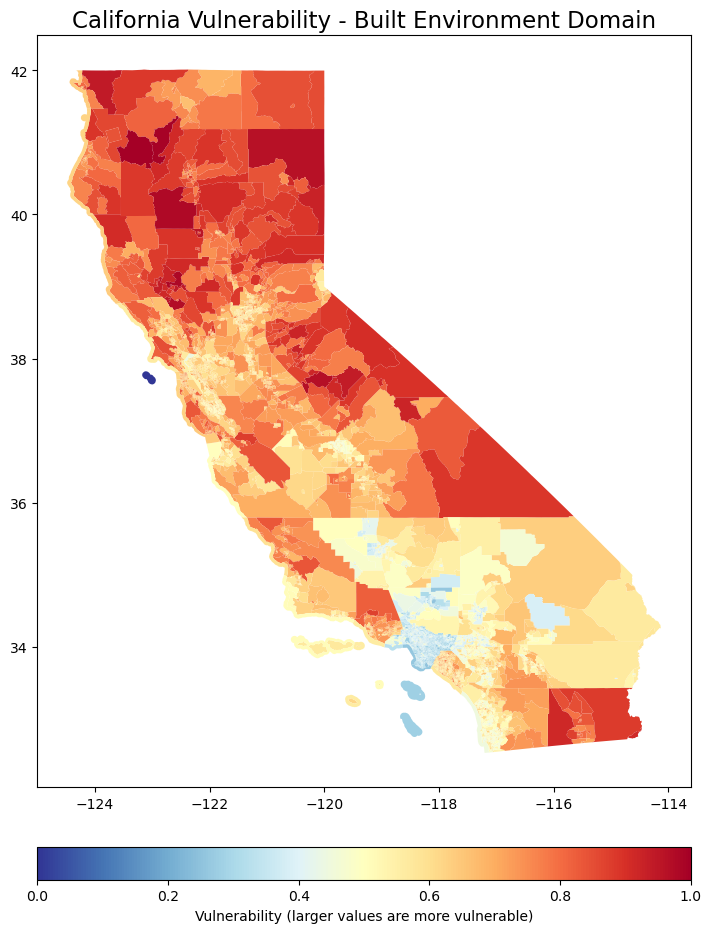

In [41]:
# Merge the DataFrames
df2 = min_max_standardized_built_domain.merge(ca_boundaries, on='GEOID')

# Convert to GeoDataFrame with the correct CRS
df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4269)

# Check for invalid geometries
invalid_geometries = df2[~df2['geometry'].is_valid]
print("Number of invalid geometries:", len(invalid_geometries))

# Check if there are any geometries left
if len(df2) == 0:
    print("No valid geometries remaining. Cannot plot.")
else:
    # Set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(7, 10), layout='compressed')

    # Plot the data
    plot = df2.plot(column='summed_indicators_built_domain_min_max_standardized', 
             ax=ax, 
             vmin=0, vmax=1, 
             legend=True, 
             cmap='RdYlBu_r',
             legend_kwds={'label': 'Vulnerability (larger values are more vulnerable)', 'orientation': 'horizontal', 'shrink': 1.0, 'pad': 0.03})
    
     # Set title
    ax.set_title('California Vulnerability - Built Environment Domain', fontsize = 16.5)

    # Display the plot
    plt.show()


In [45]:
df2.to_csv('built_index_data.csv', index=False)

In [46]:
bucket_name = 'ca-climate-index'
directory = '3_fair_data/domain_standardized_data'

upload_csv_aws(['built_index_data.csv'], bucket_name, directory)

built_index_data.csv uploaded to AWS


## Selecting counties to be mapped, by the COUNTYFP number
* manually enter the names of the counties linked with their number

Number of invalid geometries: 0


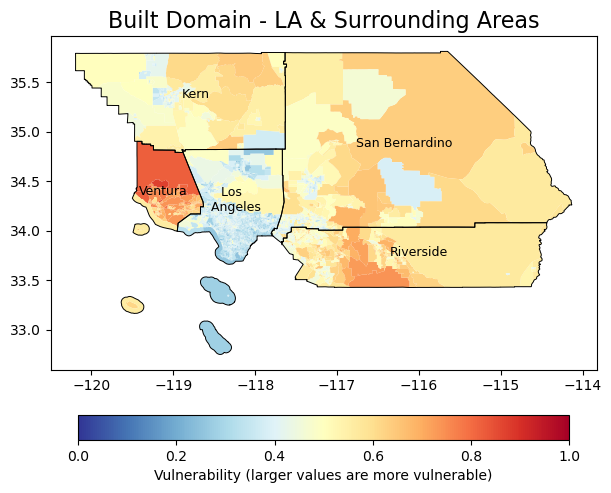

In [43]:
list_of_counties = [
    '037',
    '071',
    '065',
    '029',
    '111']

df2 = min_max_standardized_built_domain.merge(ca_boundaries, on='GEOID')

# Filtering rows where COUNTYFP is in the list_of_counties
df2_filtered = df2[df2['COUNTYFP'].isin(list_of_counties)]

# Convert to GeoDataFrame with the correct CRS
df2_filtered = gpd.GeoDataFrame(df2_filtered, geometry='geometry', crs=4269)

# Check for invalid geometries
invalid_geometries = df2_filtered[~df2_filtered['geometry'].is_valid]
print("Number of invalid geometries:", len(invalid_geometries))

# Group by COUNTYFP and take the geometry of the first row in each group
county_boundaries = df2_filtered.dissolve(by='COUNTYFP')['geometry']

# Dictionary mapping county codes to labels
county_labels = {
    '037': 'Los \n Angeles',
    '071': 'San Bernardino',
    '065': 'Riverside',
    '029': 'Kern',
    '111': 'Ventura'
}

# Set up the figure
fig, ax = plt.subplots(1, 1, figsize=(6, 12), layout='compressed')

# Plot county boundaries
county_boundaries.boundary.plot(ax=ax, linewidth=0.7, edgecolor='black')

# Plot the data
df2_filtered.plot(column='summed_indicators_built_domain_min_max_standardized', 
         ax=ax, 
         vmin=0, vmax=1, 
         legend=True, 
         cmap='RdYlBu_r', 
         legend_kwds={'label': 'Vulnerability (larger values are more vulnerable)', 'orientation': 'horizontal', 'shrink': 0.9, 'pad': -0.3})

# Add county labels
for county_code, label in county_labels.items():
    centroid = county_boundaries[county_code].centroid
    ax.text(centroid.x, centroid.y, label, weight='light', fontsize=9, ha='center', va='baseline')

ax.set_title('Built Domain - LA & Surrounding Areas', fontsize=16)

# Display the plot
plt.show()